In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

from prediction_ML_pipeline import train_and_evaluate_model
from order_imbalance import order_imbalance, combined_order_imbalance, diagnostic_plots, lm_results, iceberg_order_imbalance

In [2]:
MSFT_m = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)

In [3]:
AAPL_m2 = pd.read_csv("./data/AAPL/AAPL_2019-01-02_24900000_57900000_message_10.csv", header=None)
AAPL_m3 = pd.read_csv("./data/AAPL/AAPL_2019-01-03_24900000_57900000_message_10.csv", header=None)
AAPL_m4 = pd.read_csv("./data/AAPL/AAPL_2019-01-04_24900000_57900000_message_10.csv", header=None)

AAPL_ob2 = pd.read_csv("./data/AAPL/AAPL_2019-01-02_24900000_57900000_orderbook_10.csv", header=None)
AAPL_ob3 = pd.read_csv("./data/AAPL/AAPL_2019-01-03_24900000_57900000_orderbook_10.csv", header=None)
AAPL_ob4 = pd.read_csv("./data/AAPL/AAPL_2019-01-04_24900000_57900000_orderbook_10.csv", header=None)

AAPL_m = pd.concat([AAPL_m2, AAPL_m3, AAPL_m4])
AAPL_ob = pd.concat([AAPL_ob2, AAPL_ob3, AAPL_ob4])

In [4]:
df_m_labelled_lst = [MSFT_m]
df_ob_labelled_lst = [MSFT_ob]
tickers_train = ['MSFT']
df_m_predict_lst = [AAPL_m]
df_ob_predict_lst = [AAPL_ob]
tickers_pred = ['AAPL']

In [5]:
classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [50],
    # 'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
}


results = train_and_evaluate_model(classifier, param_grid, df_ob_labelled_lst, 
                                   df_m_labelled_lst, tickers_train,
                                   df_ob_predict_lst, df_m_predict_lst, tickers_pred)
df_labelled_dict, df_predict_dict, features_dict, prediction_dict, best_classifier = results

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
Best parameters found:  {'n_estimators': 50}
Best accuracy found:  0.9124698815818022
Accuracy on the train data: 0.9995217599234816
Accuracy on the test data: 0.9354375896700143


In [6]:
order_imbalance_AAPL = iceberg_order_imbalance(df_predict_dict['AAPL'][0], prediction_dict['pred'], delta='30S')

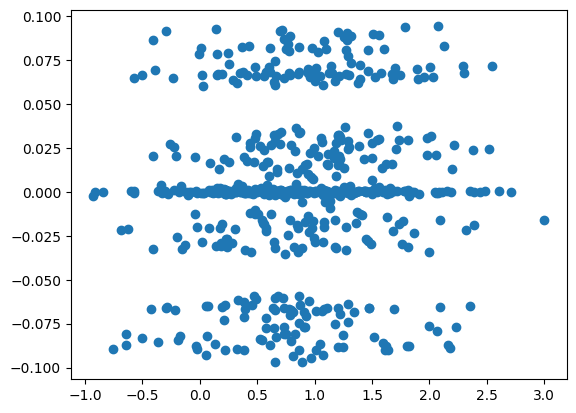

In [7]:
plt.scatter(order_imbalance_AAPL['order_imbalance_hid'][:-1], order_imbalance_AAPL['log_ret'][1:])

In [8]:
lm = smf.ols(formula="""fut_log_ret ~ order_imbalance_vis + +order_imbalance_ib+ order_imbalance_hid""", 
             data=order_imbalance_AAPL).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fut_log_ret   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.287
Date:                Fri, 19 Jul 2024   Prob (F-statistic):              0.278
Time:                        14:21:32   Log-Likelihood:                 1091.6
No. Observations:                 639   AIC:                            -2175.
Df Residuals:                     635   BIC:                            -2157.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0032      0.003     -1.108      0.268      -0.009       0.002
order_imbalance_vis    -0.0052      0.007     -0.787      0.432      -0.018       0.008
order_imbalance_ib     -0.0033      0.005     -0.653      0.514      -0.013       0.007
order_imbalance_hid     0.0048      0.003      1.769      0.077      -0.001       0.010
==============================================================================
Omnibus:                        0.358   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.836   Jarque-Bera (JB):                0.450
Skew:                          -0.044   Prob(JB):                        0.799
Kurtosis:                       2.904   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
df_results = lm_results(df_predict_dict['AAPL'][0], prediction_dict['pred'], ['15S', '30S', '1min', '5min', '10min'],
                        order_type='comb_iceberg', predictive=False)
df_results

,timeframe,params_vis,tvalues_vis,params_hid,tvalues_hid,params_ib,tvalues_ib
0,15S,-0.000616,-0.167623,0.000997,0.672439,0.000905,0.317548
1,30S,0.008829,1.327678,-0.001167,-0.430210,0.000638,0.125894
2,1min,-0.007300,-0.609930,-0.000387,-0.071256,0.005310,0.561946
3,5min,-0.034755,-0.726636,-0.012633,-0.605042,0.034581,1.028486
4,10min,-0.078177,-0.774169,0.019665,0.417761,0.098053,1.278669
